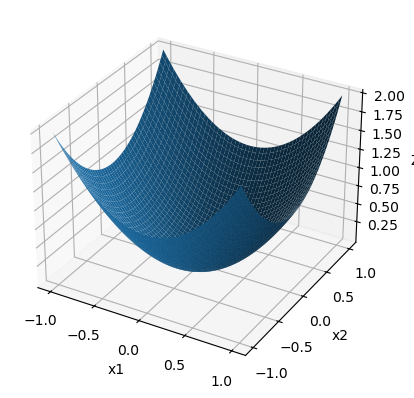

In [9]:
## Plot the data using matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x1 = np.linspace(-1, 1, 200)
x2 = np.linspace(-1, 1, 200)
##  Z = x1^2 + x2^2
data = np.array([[i, j, i**2 + j**2] for i in x1 for j in x2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(data[:,0].reshape(200, 200), data[:,1].reshape(200, 200), data[:,2].reshape(200, 200))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Z')
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)       # input layer to first hidden layer
        self.fc2 = nn.Linear(100, 100)     # first hidden layer to second hidden layer
        self.fc3 = nn.Linear(100, 50)     # second hidden layer to third hidden layer
        self.fc4 = nn.Linear(50, 1)       # third hidden layer to output layer

        self._initialize_weights()

    def _initialize_weights(self):
        # Using 'linear' as the nonlinearity ensures a gain of 1.0,
        # which is more appropriate when using GELU.
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='linear')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()


In [11]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.spatial import cKDTree

class GradPIEDataset(Dataset):
    def __init__(self, data, k=5):
        self.data = data
        self.k = min(k, len(data) - 1)  # Ensure k is not greater than the dataset size

        # Build KDTree for fast nearest neighbor search
        self.tree = cKDTree(data[:, :-1])  
        distances, indices = self.tree.query(data[:, :-1], k=self.k + 1)  # k+1 to exclude self

        self.indices = indices[:, 1:]  # Remove the first column (self-neighbor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx, :-1]  # Features
        y = self.data[idx, -1]   # Target label
        
        # Fetch the k closest neighbors' feature and label values dynamically
        neighbor_values = self.data[self.indices[idx]]

        return torch.tensor(x, dtype=torch.float32), \
               torch.tensor(y, dtype=torch.float32), \
               torch.tensor(neighbor_values[:, :-1], dtype=torch.float32), \
               torch.tensor(neighbor_values[:, -1], dtype=torch.float32)


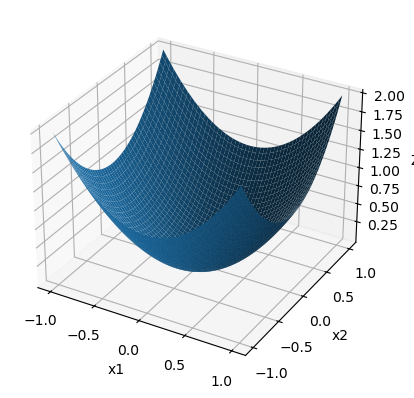

In [12]:
#plot the scaled data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(data[:,0].reshape(200, 200), data[:,1].reshape(200, 200), data[:,2].reshape(200, 200))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Z')
plt.show()

dataset = GradPIEDataset(data, 20)

In [13]:
import torch
import torch.nn.functional as F

def GradPIELossFunction(data_point, model, device='cpu'):
    x, y, neighbor_x, neighbor_y = data_point

    x = x.to(device)
    y = y.to(device)
    
    neighbor_x = neighbor_x.to(device)
    neighbor_y = neighbor_y.to(device)

    batch_size, k, feature_dim = neighbor_x.shape
    model_preds = model(x)  # shape: (batch_size, output_dim)

    # Flatten neighbor_x for a single forward pass through the model.
    neighbor_x_flat = neighbor_x.reshape(batch_size * k, feature_dim)

    # Get model predictions for neighbors.
    model_preds_neighbors = model(neighbor_x_flat)  # shape: (batch_size*k, output_dim)
    
    model_preds_neighbors = model_preds_neighbors.view(batch_size, k)
    
    diff = (neighbor_y - y.unsqueeze(1)) - (model_preds_neighbors - model_preds.unsqueeze(1))
    loss = (diff ** 2).mean()
    return loss


In [17]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Assume `dataset` and `model` (e.g., an instance of Net()) are already defined.
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up an optimizer (using Adam here)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 20  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for data_point in dataloader:
        # Zero out gradients for this batch
        optimizer.zero_grad()
        
        # Compute the GradPIE loss for the current batch.
        loss = GradPIELossFunction(data_point, model)
        # break
        # Backpropagate the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
        # break
        running_loss += loss.item()
    
    # Compute and print the average loss for the epoch
    # break
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.8f}")


Epoch 1/20, Average Loss: 0.00051139
Epoch 2/20, Average Loss: 0.00048687
Epoch 3/20, Average Loss: 0.00048205
Epoch 4/20, Average Loss: 0.00048022
Epoch 5/20, Average Loss: 0.00047917
Epoch 6/20, Average Loss: 0.00047850
Epoch 7/20, Average Loss: 0.00047823
Epoch 8/20, Average Loss: 0.00047787
Epoch 9/20, Average Loss: 0.00047754
Epoch 10/20, Average Loss: 0.00047708
Epoch 11/20, Average Loss: 0.00047706
Epoch 12/20, Average Loss: 0.00047689
Epoch 13/20, Average Loss: 0.00047693
Epoch 14/20, Average Loss: 0.00047689
Epoch 15/20, Average Loss: 0.00047670
Epoch 16/20, Average Loss: 0.00047666
Epoch 17/20, Average Loss: 0.00047637
Epoch 18/20, Average Loss: 0.00047622
Epoch 19/20, Average Loss: 0.00047617
Epoch 20/20, Average Loss: 0.00047600


Text(0.5, 0.5, 'x2')

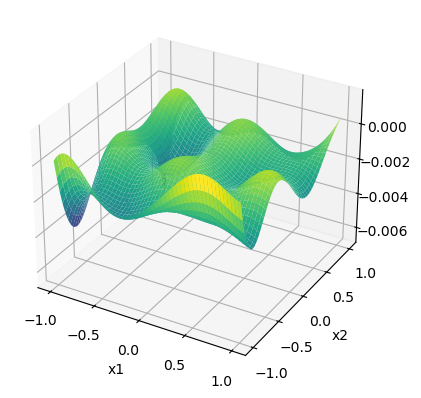

In [18]:
# i want to view the response surface orver x1 and x2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
model.eval()
x1_range = np.linspace(-1, 1, 200)
x2_range = np.linspace(-1, 1, 200)
X1, X2 = np.meshgrid(x1_range, x2_range)
X = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
X = torch.tensor(X, dtype=torch.float32)
with torch.no_grad():
    Z = model(X).numpy().reshape(X1.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')


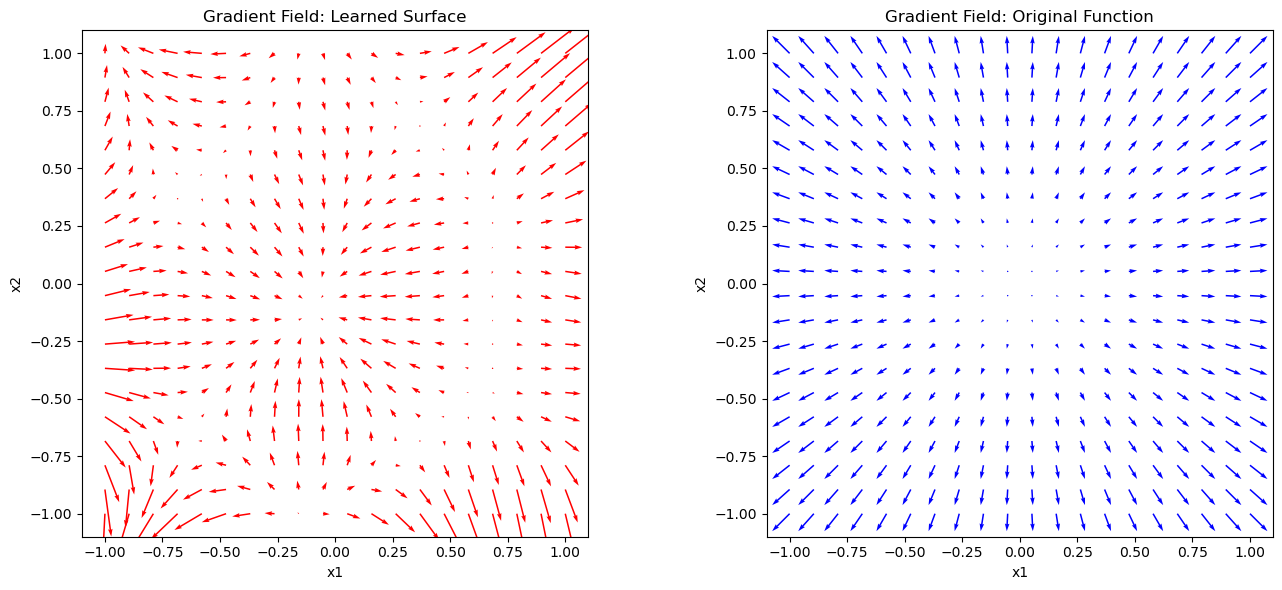

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Use a coarser grid for the quiver plot to keep arrows readable
x1_range = np.linspace(-1, 1, 20)
x2_range = np.linspace(-1, 1, 20)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Prepare grid points as inputs for the learned model gradient field
grid_points = np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1)))
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, requires_grad=True)

# Compute model outputs on the grid
output = model(grid_tensor)  # shape: (num_points, 1)

# Compute gradients of the model output with respect to inputs using autograd
gradients = torch.autograd.grad(
    outputs=output,
    inputs=grid_tensor,
    grad_outputs=torch.ones_like(output),
    create_graph=True
)[0]

# Convert gradients to NumPy arrays and reshape for plotting
gradients_np = gradients.detach().numpy()
grad_x_learned = gradients_np[:, 0].reshape(X1.shape)
grad_y_learned = gradients_np[:, 1].reshape(X2.shape)

# Compute the analytic gradient for the original function: Z = x1^2 + x2^2
# which is: dZ/dx1 = 2*x1, dZ/dx2 = 2*x2
grad_x_true = 2 * X1
grad_y_true = 2 * X2

# Create side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the learned model's gradient field
axs[0].quiver(X1, X2, grad_x_learned, grad_y_learned, color='r')
axs[0].set_title('Gradient Field: Learned Surface')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')
axs[0].set_aspect('equal')

# Plot the original function's gradient field
axs[1].quiver(X1, X2, grad_x_true, grad_y_true, color='b')
axs[1].set_title('Gradient Field: Original Function')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()
